In [1]:
import re
import glob
import random
import json
import sys

import numpy as np
import requests
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

random.seed(43)
K = 100 # number of poems to train on
WINDOW_SIZE = 30
LAYER_SIZE = 160
EPOCHS = 200
BATCH_SIZE = 64
TAG_RE = re.compile(r'<[^>]+>')
LOAD_DIR = 'saved2' # location of pretrained models (model.json and weights-*.hdf5)
SAVE_DIR = 'saved'  # location where new model and weights are stored during training

/Users/kostas/anaconda3/envs/p3-ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
"""
Prepare data
"""

def get_wiki_text(title):
    response = requests.get(
        'https://en.wikipedia.org/w/api.php',
        params={
            'action': 'query',
            'format': 'json',
            'prop': 'extracts',
            'titles': title,
            'redirects': True
         }
    ).json()

    text = ''
    for value in response['query']['pages'].values(): text += value['extract']

    text = TAG_RE.sub('', text)
    return text

def get_poems(k=10):
    for path in random.sample(glob.glob('data/*/*.json'), k = k):
        with open(path) as fi:
            poem = "\n".join(json.loads(fi.read())['text']).lower()
            yield poem

def get_alphabet(text):
    return sorted(set(text))

poems = list(get_poems(k=K))
print(poems[0])

# Mix poetry and Maersk
maersk = get_wiki_text('Maersk').lower()
poems.append(maersk)

# Get alphabet
poems_joined = ''.join(poems)
alphabet = get_alphabet(poems_joined)
print(alphabet)

n_chars = len(poems_joined)
n_distinct = len(alphabet)

print ("Total Characters: ", n_chars)
print ("Total distinct: ", n_distinct)

int_to_char = dict([(i, c) for i, c in enumerate(alphabet)])
char_to_oh = dict([(c, np.identity(n_distinct)[i: i+1][0]) for i, c in enumerate(alphabet)])

# Create one-hot-encoded training data
data_X = []
data_y = []
for poem in poems:
    for i in range(0, len(poem) - WINDOW_SIZE, 1): 
        seq_in = [char_to_oh[c] for c in poem[i: i + WINDOW_SIZE]]
        seq_out = char_to_oh[poem[i+WINDOW_SIZE]]
        data_X.append(seq_in)
        data_y.append(seq_out)
    
n_patterns = len(data_X)
print ("Total Patterns: ", n_patterns)

X = np.reshape(data_X, (n_patterns, WINDOW_SIZE, n_distinct))
y = np.reshape(data_y, (n_patterns, n_distinct))

now the rich cherry, whose sleek wood,
and top with silver petals traced
like a strict box its gems encased,
has spilt from out that cunning lid,
all in an innocent green round,
those melting rubies which it hid;
with moss ripe-strawberry-encrusted,
so birds get half, and minds lapse merry
to taste that deep-red, lark’s-bite berry,
and blackcap bloom is yellow-dusted.
the wren that thieved it in the eaves
a trailer of the rose could catch
to her poor droopy sloven thatch,
and side by side with the wren’s brood—
o lovely time of beggar’s luck—
opens the quaint and hairy bud;
and full and golden is the yield
of cows that never have to house,
but all night nibble under boughs,
or cool their sides in the moist field.
into the rooms flow meadow airs,
the warm farm baking smell’s blown round.
inside and out, and sky and ground
are much the same; the wishing star,
hesperus, kind and early born,
is risen only finger-far;
all stars stand close in summer air,
and tremble, and look mild as amber;

In [ ]:
"""
Train
"""

# Create model
model = Sequential()
model.add(LSTM(LAYER_SIZE, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.05))
model.add(LSTM(LAYER_SIZE))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Save model
model_json = model.to_json()
with open('saved/model.json', 'w') as json_file:
    json_file.write(model_json)

# define the checkpoint
#filepath = 'saved/weights-{epoch:02d}-{loss:.4f}.hdf5'
filepath = SAVE_DIR+'/weights-{epoch:03d}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Train
model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=callbacks_list)

In [22]:
"""
Use model
"""
EPSILON = 0.0000001
GEN_LENGTH = 512
DEFAULT_SEED = \
"""
I must go down to the seas again, to the lonely sea and the sky,
And all I ask is a tall ship and a star to steer her by;
And the wheel’s kick and the wind’s song and the white sail’s shaking,
And a grey mist on the sea’s face, and a grey dawn breaking.
""".lower()

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds + EPSILON).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_poetry(seed_text, model, temperature=1.0, length=200):
    # seed pattern
    pattern = [char_to_oh[c] for c in seed_text[:WINDOW_SIZE]]

    # generate characters
    for i in range(length):
        X_next = np.reshape(pattern, (1, WINDOW_SIZE, n_distinct))
        prediction = model.predict(X_next, verbose=0)
        # np.argmax(prediction)
        index = sample(prediction[0], temperature=temperature)
        predicted_char = int_to_char[index]
        padding = char_to_oh[predicted_char]
        pattern.append(padding)
        pattern = pattern[1:]
        yield predicted_char

def list_epochs(directory):
    paths = glob.glob('{}/weight*'.format(directory))
    return sorted([int(re.findall(r'weights-(\d+)', path)[0]) for path in paths])
        
def load_model(directory, epoch=None):
    """
    Load model from model.json and weights from weights-*.hdf5. 
    If epoch is specified, then load corresponding weights, 
    else latest epoch in directory.
    """
    with open('{}/model.json'.format(directory), 'r') as json_file: 
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json)
    if epoch is None:
        # Load weights with highest epoch number
        epoch = max(list_epochs(directory))
    weights = '{directory}/weights-{epoch:03d}.hdf5'.format(directory=directory, epoch=epoch)
    model.load_weights(weights)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model
        
model = load_model(LOAD_DIR)
model.summary()

print('Seed:\n', DEFAULT_SEED)
print()

for epoch in list_epochs(LOAD_DIR)[0::10]:
    # Set weights on model
    model = load_model(LOAD_DIR, epoch=epoch)
    # Generate poem
    print('Generating {}-character poem after {} iteration(s):'.format(GEN_LENGTH, epoch))
    print()
    for c in generate_poetry(DEFAULT_SEED, model, length=GEN_LENGTH):
        sys.stdout.write(c)
    print()
    print('<EOP>')        
    print()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 30, 160)           156160    
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 160)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 160)               205440    
_________________________________________________________________
dropout_10 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 83)                13363     
Total params: 374,963
Trainable params: 374,963
Non-trainable params: 0
_________________________________________________________________
Seed:
 
i must go down to the seas again, to the lonely sea and the sky,
and all i ask is a tall ship and a star to steer her by;
and th

In [ ]:
OLIVE_SEED = \
"""
a ship my ship containers are nice
I stuff my containers full of olives and mice
the waves lay gently a craddle of money
my future is golden from olives and honey
"""

BEST_EPOCH = 43

model = load_model(LOAD_DIR, epoch=BEST_EPOCH)

for temp in range(1, 101, 10):
    temp = (temp or 1) / 100
    print ('Generate poem with temperature:', temp)
    for c in generate_poetry(OLIVE_SEED, model, temperature=0.01, length=GEN_LENGTH):
        sys.stdout.write(c)
    print()
    print('<EOP>')
    print()



In [6]:
fragment = 'the brides are'
fragment in ''.join(poems)

False

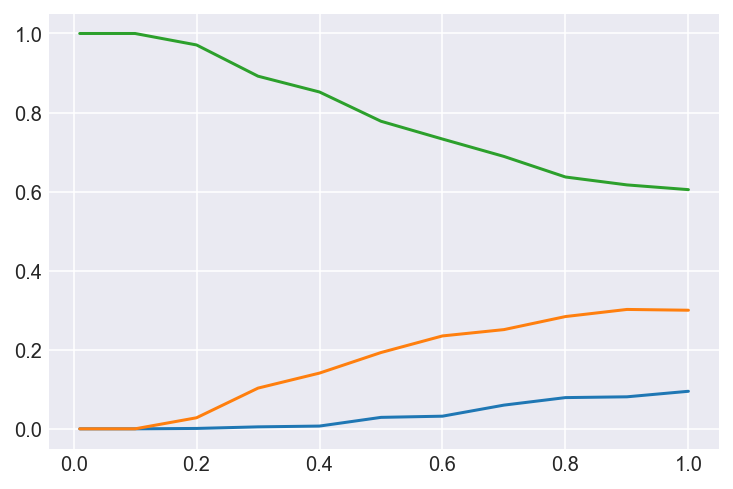

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['figure.dpi']= 144

trials = 1000
softmax = [0.1, 0.3, 0.6]

def sample(softmax, temperature):
    EPSILON = 10e-16 # to avoid taking the log of zero
    #print(preds)
    (np.array(softmax) + EPSILON).astype('float64')
    preds = np.log(softmax) / temperature
    #print(preds)
    exp_preds = np.exp(preds)
    #print(exp_preds)
    preds = exp_preds / np.sum(exp_preds)
    #print(preds)
    probas = np.random.multinomial(1, preds, 1)
    return probas[0]

temperatures = [(t or 1) / 100 for t in range(0, 101, 10)]
probas = [
    np.asarray([sample(softmax, t) for _ in range(trials)]).sum(axis=0) / trials
    for t in temperatures
]

sns.set_style("darkgrid")
plt.plot(temperatures, probas)
plt.show()